# LLMs

In [18]:
import sys
sys.path.append("..")
from src.Eval import eval_llm

import os
import io
from contextlib import redirect_stdout

def parse_filename(filename):
    parts = filename.split("_")
    dataset = parts[0]
    k_shot = parts[1].split(".")[0]
    k = int(k_shot.replace("shot", ""))
    return dataset, k

def silent_eval_llm(fpath):
    with io.StringIO() as buf, redirect_stdout(buf):
        # Call the actual eval_llm function
        return eval_llm(fpath)
    
def aggregated_results_llm(
    results_dir,
    ent_types=["overall", "Artist", "WoA"],
    eval_schemas=["strict", "exact", "ent_type"],
    metrics=["f1", "f1_macro", "precision", "precision_macro", "recall", "recall_macro", "missed", "spurious", "incorrect"],
    datasets=["dataset1", "dataset2", "dataset3", "dataset4"],
    ks=[0,5,15,25,35,45]
):
    results = {}
    for metric in metrics:
        results[metric] = {}
        for schema in eval_schemas:
            results[metric][schema] = {}
            for ent_type in ent_types:
                results[metric][schema][ent_type] = {}
                for model in [m for m in os.listdir(results_dir) if m != "archive"]:
                    results[metric][schema][ent_type][model] = {}
                    for k in ks:
                        results[metric][schema][ent_type][model][k] = []

    model_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d != "archive"
    ]

    for model_dir in model_dirs:
        model = model_dir.split(os.sep)[-1]
        files = [
            os.path.join(model_dir, f)
            for f in os.listdir(model_dir)
            if os.path.isfile(os.path.join(model_dir, f))
        ]

        for fpath in files:
            filename = os.path.basename(fpath)
            dataset, k = parse_filename(filename)

            if dataset in datasets and k in ks:
                predictions = silent_eval_llm(fpath)

                for ent_type in ent_types:
                    for schema in eval_schemas:
                        for metric in metrics:
                            key = f"{ent_type}_{schema}_{metric}"
                            if key in predictions.keys():
                                results[metric][schema][ent_type][model][k].append(predictions[key])
    return results

results_rand = aggregated_results_llm("../output/rand_sampling")
results_tfidf = aggregated_results_llm("../output/tfidf_sampling")


2024-07-11 14:10:33 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:34 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:34 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:34 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:34 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:34 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:34 root INFO: Imported 751 predictions for 751 true examples
2024-07-11 14:10:35 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:35 root INFO: Imported 751 predictions for 751 true examples
2024-07-11 14:10:35 root INFO: Imported 751 predictions for 751 true examples
2024-07-11 14:10:35 root INFO: Imported 751 predictions for 751 true examples
2024-07-11 14:10:35 root INFO: Imported 600 predictions for 600 true examples
2024-07-11 14:10:36 root INFO: Imported 600 predictions for 600 

In [19]:
import pandas as pd
import numpy as np

def results_to_dataframe(aggregated_results, metric, agg_func='mean'):
    data = []

    for schema, schema_dict in aggregated_results[metric].items():
        for ent_type, ent_type_dict in schema_dict.items():
            for model, model_dict in ent_type_dict.items():
                for k_shot, values in model_dict.items():
                    if values:
                        if agg_func == 'mean':
                            agg_value = np.mean(values)
                        elif agg_func == 'sum':
                            agg_value = np.sum(values)
                        else:
                            raise ValueError("Invalid aggregation function. Use 'mean' or 'sum'.")
                        
                        data.append([schema, ent_type, model, k_shot, agg_value])

    df = pd.DataFrame(data, columns=['Schema', 'Entity Type', 'Model', 'k', 'Value'])
    df.Model = df.Model.str.replace("mistral", "Mistral-7B").str.replace("mixtral", "Mixtral-8x22B").str.replace("gpt-3.5-turbo-0125", "GPT-3.5-Turbo")
    return df.set_index(["Schema", "Entity Type", "Model", "k"])


# Precision 

In [83]:
results = results_to_dataframe(results_tfidf, "precision", "mean").reset_index()
results[(results.Schema == "strict") & (results.k == 35)].drop(["Schema", "k"], axis=1)



,Entity Type,Model,Value
3,Artist,Mistral-7B,0.777103
8,Artist,GPT-3.5-Turbo,0.907031
13,Artist,Mixtral-8x22B,0.889135
18,WoA,Mistral-7B,0.736221
23,WoA,GPT-3.5-Turbo,0.636991
28,WoA,Mixtral-8x22B,0.765298


# Recall

In [82]:
results = results_to_dataframe(results_tfidf, "recall", "mean").reset_index()
results[(results.Schema == "strict") & (results.k == 35)].drop(["Schema", "k"], axis=1)



,Entity Type,Model,Value
3,Artist,Mistral-7B,0.705581
8,Artist,GPT-3.5-Turbo,0.781502
13,Artist,Mixtral-8x22B,0.776952
18,WoA,Mistral-7B,0.607756
23,WoA,GPT-3.5-Turbo,0.649343
28,WoA,Mixtral-8x22B,0.721376


In [21]:
results_to_dataframe(results_tfidf, "f1_macro", "mean")


Value
Schema   Entity Type Model         k           
strict   overall     Mistral-7B    5   0.647793
                                   15  0.703132
                                   25  0.719543
                                   35  0.702602
                                   45  0.712189
                     GPT-3.5-Turbo 5   0.671934
                                   15  0.726839
                                   25  0.742100
                                   35  0.741083
                                   45  0.748914
                     Mixtral-8x22B 5   0.740377
                                   15  0.771968
                                   25  0.779327
                                   35  0.785903
                                   45  0.773778
exact    overall     Mistral-7B    5   0.673217
                                   15  0.725480
                                   25  0.742650
                                   35  0.722943
                                   45  0.736032
                     GPT-3.5-Turbo 5   0.682833
                                   15  0.737458
                                   25  0.752199
                                   35  0.753087
                                   45  0.761032
                     Mixtral-8x22B 5   0.765125
                                   15  0.799604
                                   25  0.804366
                                   35  0.805535
                                   45  0.794910
ent_type overall     Mistral-7B    5   0.704683
                                   15  0.763867
                                   25  0.778269
                                   35  0.767788
                                   45  0.775743
                     GPT-3.5-Turbo 5   0.738150
                                   15  0.787413
                                   25  0.807935
                                   35  0.804578
                                   45  0.808874
                     Mixtral-8x22B 5   0.791089
                                   15  0.821778
                                   25  0.824701
                                   35  0.832237
                                   45  0.818655

# Figure: F1 Scores with Strict Evaluation

2024-07-11 14:32:08 matplotlib.backends.backend_pdf DEBUG: Assigning font /F1 = '/data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2024-07-11 14:32:08 matplotlib.backends.backend_pdf DEBUG: Embedding font /data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2024-07-11 14:32:08 matplotlib.backends.backend_pdf DEBUG: Writing TrueType font.


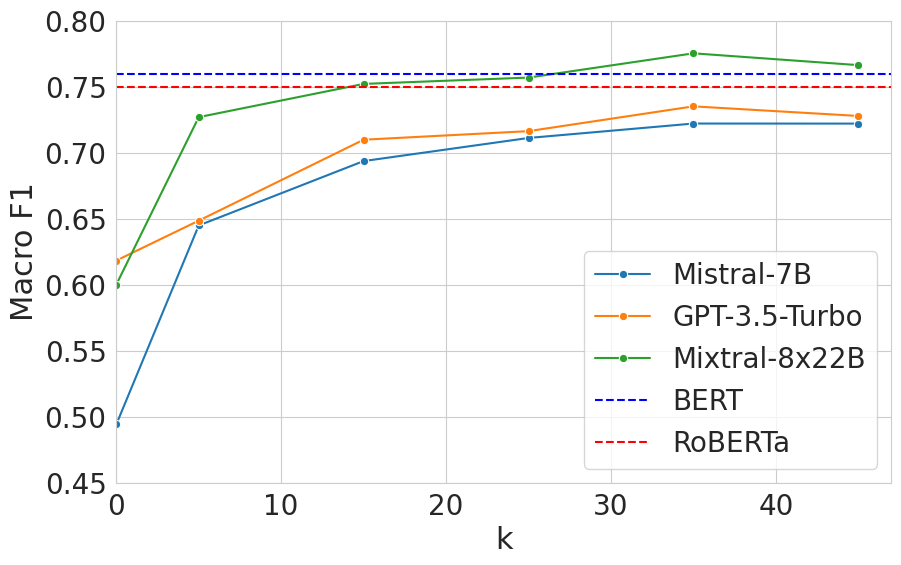

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
df_results = results_to_dataframe(results_rand, "f1_macro", "mean")
df_results = df_results[df_results.index.get_level_values('Model') != 'llama3']

df_plot = df_results.loc["strict"].loc["overall"]

# Create the Seaborn plot
plt.rcParams.update({'xtick.labelsize': 20, 'ytick.labelsize': 20})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='k', y='Value', hue='Model', marker='o')

# Add horizontal lines at specific values (e.g., 0.75 and 0.78)
f1_scores = [0.76, 0.75]
colors = ['b', 'r']  # Colors for the lines
baselines = ["BERT", "RoBERTa"]

for value, color, model in zip(f1_scores, colors, baselines):
    plt.axhline(y=value, color=color, linestyle='--', label=model)

# Create custom legend entries for the horizontal lines
handles, labels = plt.gca().get_legend_handles_labels()
for value, color, model in zip(f1_scores, colors, baselines):
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--'))
    labels.append(model)

plt.legend(handles=handles, title='Model')

#plt.title('Values by k and Model')
plt.xlabel('k', fontsize=22)
plt.ylabel('Macro F1', fontsize=22)
plt.xlim((0,47))
plt.ylim((0.45,0.8))
plt.legend(fontsize=20)
plt.savefig("../figures/rand_strict_overall.pdf")
plt.show()


2024-07-11 14:32:23 matplotlib.backends.backend_pdf DEBUG: Assigning font /F1 = '/data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2024-07-11 14:32:23 matplotlib.backends.backend_pdf DEBUG: Embedding font /data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2024-07-11 14:32:23 matplotlib.backends.backend_pdf DEBUG: Writing TrueType font.


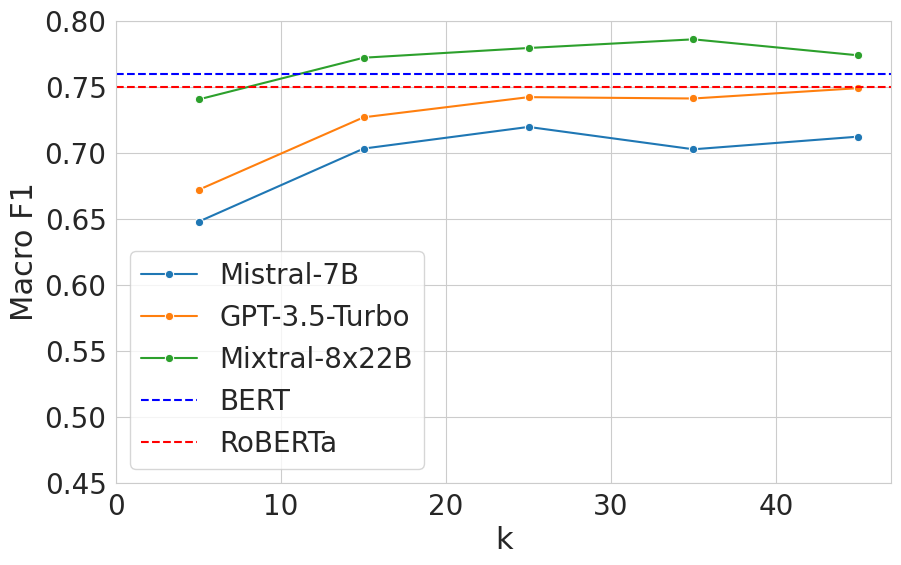

In [53]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
df_results = results_to_dataframe(results_tfidf, "f1_macro", "mean")
df_results = df_results[df_results.index.get_level_values('Model') != 'llama3']

df_plot = df_results.loc["strict"].loc["overall"]

# Create the Seaborn plot
plt.rcParams.update({'xtick.labelsize': 20, 'ytick.labelsize': 20})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='k', y='Value', hue='Model', marker='o')

# Add horizontal lines at specific values (e.g., 0.75 and 0.78)
f1_scores = [0.76, 0.75]
colors = ['b', 'r']  # Colors for the lines
baselines = ["BERT", "RoBERTa"]

for value, color, model in zip(f1_scores, colors, baselines):
    plt.axhline(y=value, color=color, linestyle='--', label=model)

# Create custom legend entries for the horizontal lines
handles, labels = plt.gca().get_legend_handles_labels()
for value, color, model in zip(f1_scores, colors, baselines):
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--'))
    labels.append(model)

plt.legend(handles=handles, title='Model')

#plt.title('Values by k and Model')
plt.xlabel('k', fontsize=22)
plt.ylabel('Macro F1', fontsize=22)
plt.xlim((0,47))
plt.ylim((0.45,0.8))
plt.legend(fontsize=20)
plt.savefig("../figures/tfidf_strict_overall.pdf")
plt.show()


# Baseline: BERT etc.

In [25]:
import importlib
sys.path.append('../baseline/music-ner-eacl2023/music-ner/tables-and-stats')
transformer_baselines = importlib.import_module("transformer_baselines")
from transformer_baselines import model_results, print_latex_table

print_latex_table(model_results(
    "../baseline/music-ner-eacl2023/output/", 
    ["bert-large-uncased", "roberta-large", "mpnet-base"]))


bert-large-uncased & 0.8 $\pm$ 0.03 & 0.72 $\pm$ 0.06 & 0.76 $\pm$ 0.04 
roberta-large & 0.79 $\pm$ 0.03 & 0.72 $\pm$ 0.04 & 0.75 $\pm$ 0.02 
mpnet-base & 0.81 $\pm$ 0.03 & 0.73 $\pm$ 0.06 & 0.77 $\pm$ 0.04 


In [50]:
import sys
sys.path.append("..")
from src.Eval import compute_results_jsonl, compute_results_txt
from src.Utils import get_true_pred_entities, read_IOB_file
from baseline.parse_output import get_results_overall_table, get_results_table, parse_preds_baseline

BASELINES = ["bert-large-uncased", "roberta-large", "mpnet-base"]
OUTPUT_PATH_REDDIT = "../baseline/music-ner-eacl2023/output/dataset"

results_f1 = get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(1)).loc["macro", "strict", "f1"]
for i in range(2,5):
    results_f1 += get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i)).loc["macro", "strict", "f1"]
results_f1 =  results_f1/4
results_f1


Model
bert-large-uncased    0.762891
mpnet-base            0.768399
roberta-large         0.752712
Name: (macro, strict, f1), dtype: float64

In [51]:


results_attrs = get_results_table(BASELINES, OUTPUT_PATH_REDDIT + str(1))
for i in range(2,5):
    results_attrs += get_results_table(BASELINES, OUTPUT_PATH_REDDIT + str(1))
results_attrs =  results_attrs/4
results_attrs


f1                                          \
Attribute             Artist                           WoA             
Scenario               exact    strict      type     exact    strict   
Model                                                                  
bert-large-uncased  0.866557  0.813839  0.830313  0.779582  0.747100   
mpnet-base          0.851974  0.796053  0.819079  0.779904  0.741627   
roberta-large       0.815182  0.775578  0.798680  0.765258  0.732394   

                             precision                                \
Attribute                       Artist                           WoA   
Scenario                type     exact    strict      type     exact   
Model                                                                  
bert-large-uncased  0.807425  0.865132  0.812500  0.828947  0.753363   
mpnet-base          0.813397  0.849180  0.793443  0.816393  0.776190   
roberta-large       0.812207  0.815182  0.775578  0.798680  0.747706   

                                          recall                      \
Attribute                                 Artist                       
Scenario              strict      type     exact    strict      type   
Model                                                                  
bert-large-uncased  0.721973  0.780269  0.867987  0.815182  0.831683   
mpnet-base          0.738095  0.809524  0.854785  0.798680  0.821782   
roberta-large       0.715596  0.793578  0.815182  0.775578  0.798680   

                                                  
Attribute                WoA                      
Scenario               exact    strict      type  
Model                                             
bert-large-uncased  0.807692  0.774038  0.836538  
mpnet-base          0.783654  0.745192  0.817308  
roberta-large       0.783654  0.750000  0.831731

f1                                          \
Attribute             Artist                           WoA             
Scenario               exact    strict      type     exact    strict   
Model                                                                  
bert-large-uncased  0.866557  0.813839  0.830313  0.779582  0.747100   
mpnet-base          0.851974  0.796053  0.819079  0.779904  0.741627   
roberta-large       0.815182  0.775578  0.798680  0.765258  0.732394   

                             precision                                \
Attribute                       Artist                           WoA   
Scenario                type     exact    strict      type     exact   
Model                                                                  
bert-large-uncased  0.807425  0.865132  0.812500  0.828947  0.753363   
mpnet-base          0.813397  0.849180  0.793443  0.816393  0.776190   
roberta-large       0.812207  0.815182  0.775578  0.798680  0.747706   

                                          recall                      \
Attribute                                 Artist                       
Scenario              strict      type     exact    strict      type   
Model                                                                  
bert-large-uncased  0.721973  0.780269  0.867987  0.815182  0.831683   
mpnet-base          0.738095  0.809524  0.854785  0.798680  0.821782   
roberta-large       0.715596  0.793578  0.815182  0.775578  0.798680   

                                                  
Attribute                WoA                      
Scenario               exact    strict      type  
Model                                             
bert-large-uncased  0.807692  0.774038  0.836538  
mpnet-base          0.783654  0.745192  0.817308  
roberta-large       0.783654  0.750000  0.831731

In [40]:
get_mean_results(BASELINES, OUTPUT_PATH_REDDIT, eval_scheme="strict", metric="precision")

Model
bert-large-uncased    0.753260
mpnet-base            0.764751
roberta-large         0.747194
Name: (macro, strict, precision), dtype: float64

In [30]:
get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i)).loc["macro", "strict", "f1"] + get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i-1)).loc["macro", "strict", "f1"]


Model
bert-large-uncased    1.464879
mpnet-base            1.475189
roberta-large         1.474386
Name: (macro, strict, f1), dtype: float64

In [3]:
get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i))


Model                     bert-large-uncased  mpnet-base  roberta-large
      Scenario Metric                                                  
macro exact    actual             335.000000  323.000000     332.500000
               correct            254.000000  254.500000     258.500000
               f1                   0.760256    0.777097       0.779734
               incorrect           20.000000   16.000000      18.000000
               missed              52.500000   56.000000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.750064    0.781029       0.773219
               recall               0.770820    0.773218       0.786394
               spurious            61.000000   52.500000      56.000000
      strict   actual             335.000000  323.000000     332.500000
               correct            232.500000  233.000000     239.000000
               f1                   0.692649    0.704873       0.715011
               incorrect           41.500000   37.500000      37.500000
               missed              52.500000   56.000000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.683511    0.708558       0.708885
               recall               0.702118    0.701238       0.721275
               spurious            61.000000   52.500000      56.000000
      type     actual             335.000000  323.000000     332.500000
               correct            252.500000  249.000000     257.000000
               f1                   0.759453    0.759926       0.773643
               incorrect           21.500000   21.500000      19.500000
               missed              52.500000   56.000000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.749104    0.763778       0.767138
               recall               0.770182    0.756126       0.780292
               spurious            61.000000   52.500000      56.000000
micro exact    actual             670.000000  646.000000     665.000000
               correct            508.000000  509.000000     517.000000
               f1                   0.767952    0.783680       0.784522
               incorrect           40.000000   32.000000      36.000000
               missed             105.000000  112.000000     100.000000
               partial              0.000000    0.000000       0.000000
               possible           653.000000  653.000000     653.000000
               precision            0.758209    0.787926       0.777444
               recall               0.777948    0.779479       0.791730
               spurious           122.000000  105.000000     112.000000
      strict   actual             670.000000  646.000000     665.000000
               correct            465.000000  466.000000     478.000000
               f1                   0.702948    0.717475       0.725341
               incorrect           83.000000   75.000000      75.000000
               missed             105.000000  112.000000     100.000000
               partial              0.000000    0.000000       0.000000
               possible           653.000000  653.000000     653.000000
               precision            0.694030    0.721362       0.718797
               recall               0.712098    0.713629       0.732006
               spurious           122.000000  105.000000     112.000000
      type     actual             670.000000  646.000000     665.000000
               correct            505.000000  498.000000     514.000000
               f1                   0.763416    0.766744       0.779970
               incorrect           43.00

### Takeaways from Overall
- at least for few-shot, BERT-like models seem to be better than LLaMa-3

# Error Analysis
### BERT on Dataset4

In [16]:
data = get_true_pred_entities(
    "bert-large-uncased", "../baseline/music-ner-eacl2023/output/dataset" + str(4)).dropna(
        how="all")

mask_artist = (data.Artist_true != data.Artist_pred) & ~(data.Artist_true.isna() & data.Artist_pred.isna())
mask_woa = (data.WoA_true != data.WoA_pred) & ~(data.WoA_true.isna() & data.WoA_pred.isna())

data.loc[(mask_woa | mask_artist), 
         ["text", "WoA_true", "WoA_pred", "Artist_true", "Artist_pred"]
         ].sample(frac=1).to_csv("../output/reddit/error_analysis/d4.csv")


##### Errors at WoA

##### Errors at Artist

# Ideas
### Stabilize
- Always: "Does the entity X refer to a Work of Art or a musical Artist?"
- If no entity found: "Is there no entity referring to a Work of Art (WoA) or a musical Artist?"
### Understandability
- If there is a WoA in this text, how did you identify it?
- If there is an Artist in this text, how did you identify it?
- Did you use linguistic knowledge to identify entities or did you 
